## Extreme Gradient Boosting Model
This notebook includes all relevant code regarding the implementation of XGB for short term load forecasting as part of the EG2140 project course.

Authors: Florian Kühn, (Andreas Liv, Ali Kamran)

In [ ]:
#pip install -r requirements_XGB.txt

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, holidays
import xgboost as xgb
import joblib
from xgboost import XGBRegressor
from darts.models import NaiveSeasonal
from darts import TimeSeries
from sklearn.model_selection import PredefinedSplit, RandomizedSearchCV
from scipy.stats import randint, uniform
from datetime import timedelta
from darts.metrics import mape, rmse, mae

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 22})

/Users/floriankuhn/Desktop/MachineLearning/Load-Forecasting/dartenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The following two functions are used to evaluate the forecasted values with respect to actual measurements. For greater clarity, the code was structured into separate functions.

In [ ]:
def print_evaluation_metrics(actual,predicted):
    '''
    Evaluation function printing out the following error metrics:
     - Mean Absolute Percentage Error (MAPE): mainly used for classification of model accuracy
     - Mean Absolute Error (MAE): used for getting a physical interpretation of what the obtained error means (MW deviation)
     - Root Mean Squared Error (RMSE): used to measure how forecasts predict outliers: higher values mean worse outlier prediction
     - Days with maximum and minimum MAPE in the considered test range
     
     Darts error metrics functions were preferred over scikit-learn, as they handle extreme values better.
    '''
    # time series conversion to use Darts error metrics
    actual_series = TimeSeries.from_series(actual)
    predicted_series = TimeSeries.from_series(predicted)
    
    mape_val = mape(actual_series, predicted_series)
    rmse_val = rmse(actual_series, predicted_series)
    mae_val = mae(actual_series, predicted_series)

    print(f"MAPE: {mape_val:.2f}%")
    print(f"RMSE: {rmse_val:.2f}")
    print(f"MAE: {mae_val:.2f}MW")
    
    # Min/Max MAPE calculation
     
    df = pd.DataFrame({
        'actual': actual,
        'predicted': predicted
    })
    df.index = pd.to_datetime(df.index) 

    df = df[df['actual'] != 0] # filter out zero-values to avoid division by 0

    df['date'] = df.index.date

    df['abs_pct_error'] = np.abs(df['actual'] - df['predicted']) / df['actual'] # manual MAPE calculation according to Darts definition

    daily_mape = df.groupby('date')['abs_pct_error'].mean() * 100 # convert to %

    max_mape_value = daily_mape.max()
    min_mape_value = daily_mape.min()
    max_mape_date = daily_mape.idxmax()
    min_mape_date = daily_mape.idxmin()

    print(f"Maximum MAPE: {max_mape_value:.2f}% on {max_mape_date}")
    print(f"Minimum MAPE: {min_mape_value:.2f}% on {min_mape_date}")
    
def plot_forecast(actual, predicted, model, model_name=None, xgb_feat=False):
    '''
    Plot function printing the "actual" measured and "predicted" load sets using a given "model".
    If "model_name" is given, saves the plot to a pdf file with that string as name.
    If "xgb_feat" is given, prints XGBs feature importance plot
    '''
    start_date = actual.index[0].strftime('%Y-%m-%d')
    end_date = actual.index[0].strftime('%Y-%m-%d')
    
    plt.figure(figsize=(12, 6))
    actual.plot(label='Actual', lw=1)
    predicted.plot(label='Forecast', lw=1)
    plt.legend()
    plt.title('Load Forecast ({} to {})'.format(start_date,end_date))
    plt.xlabel('Date')
    plt.ylabel('Load (MW)')
    plt.grid(True)
    plt.tight_layout()
    if model_name:
        plt.savefig(model_name, format="pdf", bbox_inches="tight")
    plt.show()

    # Feature Importance Plot
    if xgb_feat:
        xgb.plot_importance(model, height=0.6, max_num_features=50)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.show()

In [358]:
def read_load_data():
    base_dir = os.getcwd()
    load_file_path = os.path.join(base_dir, 'processed_loadUTC_data.csv')
    load_data = pd.read_csv(load_file_path)
    load_data.rename(columns={
        "Actual Total Load [MW] - BZN|SE4": "Actual Load",
        "Time (UTC)": "Time"
    }, inplace=True)
    load_data['Time'] = pd.to_datetime(load_data['Time'].str.split(' - ').str[0], format='%d.%m.%Y %H:%M')
    load_data.set_index('Time', inplace=True)
    load_data.drop('Day-ahead Total Load Forecast [MW] - BZN|SE4', axis=1, inplace=True)
    return load_data

data = read_load_data()

MAPE: 9.13%
RMSE: 348.70
MAE: 241.89MW
Maximum MAPE: 42.34% on 2024-11-26
Minimum MAPE: 1.73% on 2024-02-15


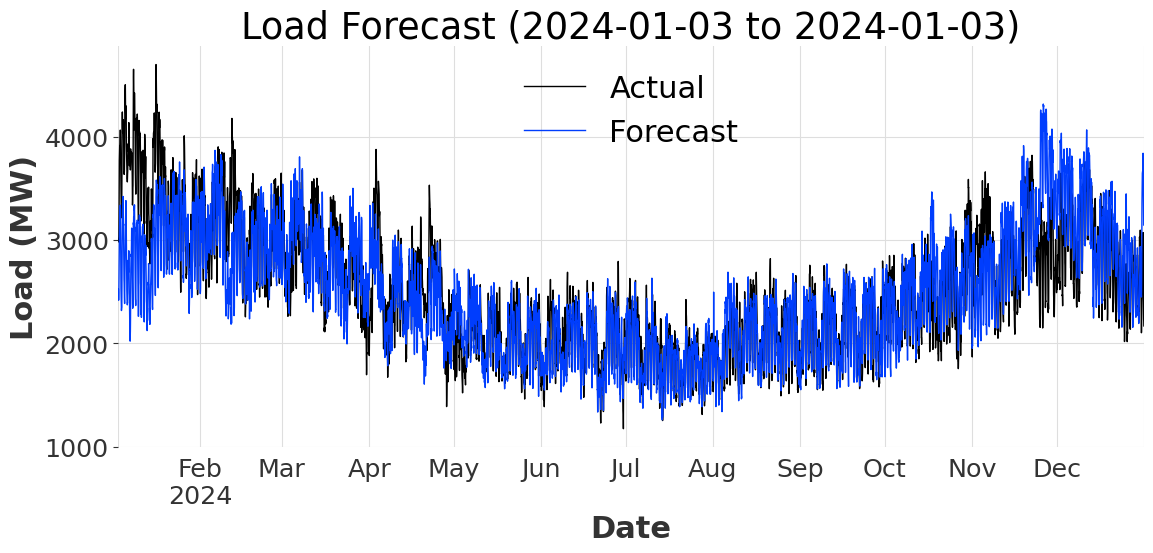

In [359]:
# Load data
forecast_data = data['Actual Load']
series = TimeSeries.from_series(forecast_data)

# Define target forecast length (e.g. one year = 366 days)
full_hours = 24 * 366  # 8784 hours

# Make sure test set ends on final timestamp
test_end = series.end_time()

# Adjust start so that the time window is a multiple of 168 (full weeks)
hours_to_trim = full_hours % 168  # remove excess to get full weeks only
test_start = test_end - timedelta(hours=(full_hours - hours_to_trim) - 1)

# Create actual and training sets
actual = series.slice(test_start, test_end)
train = series.drop_after(test_start - timedelta(hours=1))

# Fit model
model = NaiveSeasonal(K=len(actual))
model.fit(train)

# Forecast for the same length as the actual set
forecast = model.predict(len(actual))

# Convert to pandas Series
actual_pd = actual.to_series()
forecast_pd = forecast.to_series()

print_evaluation_metrics(actual_pd,forecast_pd)

plot_forecast(actual_pd,forecast_pd,model, "NSM.pdf")

In [360]:
def import_weather_data(df, solar_power=False):
    base_dir = os.getcwd()
    temperature_file_path = os.path.join(base_dir, 'weighted_avg_temp.csv')
    humidity_file_path = os.path.join(base_dir, 'weighted_avg_humidity.csv')
    solar_file_path = os.path.join(base_dir, 'weighted_avg_solar.csv')
    avg_temperature_data = pd.read_csv(temperature_file_path)
    avg_humidity_data = pd.read_csv(humidity_file_path)
    avg_solar_data = pd.read_csv(solar_file_path)
    df['Temperature'] = avg_temperature_data['weighted_avg'].values
    df['Humidity'] = avg_humidity_data['weighted_avg'].values
    df['Solar_Irrad'] = avg_solar_data['weighted_avg'].values
    
    if solar_power:
        tot_installed_capacity = np.array([2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85])*1e6
        installed_capacity_house = 10*1e3
        n_installations = tot_installed_capacity / installed_capacity_house
        panel_per_house = 24
        area_per_panel = 2

        years = np.arange(2015, 2025)
        total_area_panels = n_installations * panel_per_house * area_per_panel
        area_by_year = dict(zip(years, total_area_panels))

        panel_efficiency = 0.2
        df['year'] = df.index.year
        df['Solar'] = df['Solar_Irrad'] * data['year'].map(area_by_year) * panel_efficiency
        df.drop(columns='year', inplace=True)
    else:
        df['Solar'] = df['Solar_Irrad']
    df.drop(columns='Solar_Irrad',inplace=True)
    return df

data = import_weather_data(data, solar_power=True)

In [361]:
def import_swedish_holidays(df):
    years = np.arange(2015, 2025)
    raw_holidays = []
    for date, name in sorted(holidays.Sweden(years=years).items()):
        if not name == "Söndag":
            raw_holidays.append(date)
        raw_holidays.append(date)
    holiday_dates = set(raw_holidays)
    df['is_holiday'] = pd.Series(df.index.date).isin(holiday_dates).astype(int).values
    return df

data = import_swedish_holidays(data)

In [362]:
def create_date_features(df):
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    return df

data = create_date_features(data)

In [364]:
def add_noise_to_covariates(df, noise_level: float = 0.05):
    stochastic_cols = ["Temperature", "Humidity",  "Solar"]#
    df_noisy = df.copy()

    for col in stochastic_cols:
        if col in df_noisy.columns:
            if col == "Solar":
                # Proportional noise based on value (avoid large noise when value is 0)
                base = df_noisy[col].values
                noise = np.random.normal(0, noise_level * base)
                df_noisy[col] += noise
                df_noisy[col] = df_noisy[col].clip(lower=0)  # Prevent negative solar
            else:
                # Standard deviation-based noise
                std = df_noisy[col].std()
                noise = np.random.normal(0, noise_level * std, size=len(df_noisy))
                df_noisy[col] += noise

    return df_noisy

future_data = add_noise_to_covariates(data)

In [365]:
def create_lag_features(df, load="Actual Load", nan=False):
    df = df.copy()
    for lag in [1, 2, 3, 6, 12, 24]: 
        df[f'lag_temp_{lag}'] = df["Temperature"].shift(lag)
        df[f'lag_humid_{lag}'] = df["Humidity"].shift(lag)
        df[f'lag_solar_{lag}'] = df["Solar"].shift(lag)
        if lag <=3:
            df[f'lag_hour_{lag}'] = df["hour"].shift(lag)
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)

    for day in range(2, 8):  # Start from 2*24 = 48 to avoid lag_24 duplication
        lag = day * 24
        if nan:
            df[f'lag_{lag}'] = np.nan
        else:
            df[f'lag_{lag}'] = df[load].shift(lag)
    

    return df

data = create_lag_features(data)
data = data.dropna() # first week in 2015 dropped to enable lag features
future_data = create_lag_features(future_data, nan=True)
future_data = future_data[future_data.index >= data.index.min()]

In [366]:
# Time-based train/test split
split_dates = ['2015-01-01','2024-01-01','2024-01-08', '2024-07-01', '2024-07-08', '2024-12-31']
train = data[(data.index>=split_dates[0])&(data.index<split_dates[1])]              

def define_sets(init_start_date, init_end_date, end_of_eval_period):
    init_set = data[(data.index>=init_start_date)&(data.index<init_end_date)]  
    set_pred = future_data[(future_data.index>=init_end_date)&(future_data.index<end_of_eval_period)]  
    set_known = data[(data.index>=init_start_date)&(data.index<end_of_eval_period)]
    return init_set, set_pred, set_known

init_val_set, val_set_pred, val_set_known = define_sets(split_dates[1],
                                                        split_dates[2],
                                                        split_dates[3])
init_test_set, test_set_pred, test_set_known = define_sets(split_dates[3],
                                                           split_dates[4],
                                                           split_dates[5])

In [367]:
features = [col for col in data.columns if col not in ['Actual Load']]
X_train, y_train = train[features], train['Actual Load'] 

def target_feature_split(init_set, pred, known, features, target):
    X_init, y_init = init_set[features], init_set[target] # for initialisation of forecast period

    # to fill the first 12 hours per day with actual measured loads 
    X_known, y_known = known[features], known[target] 

    # lags features will later be filled with forecasted values
    X_pred, y_pred = pred[features], pred[target]
    
    return X_init,y_init,X_known,y_known,X_pred,y_pred

X_val_init,y_val_init,X_val_known,y_val_known,X_val_pred,y_val_pred = target_feature_split(init_val_set,
                                                                                           val_set_pred,
                                                                                           val_set_known,
                                                                                           features,
                                                                                           "Actual Load")

X_test_init,y_test_init,X_test_known,y_test_known,X_test_pred,y_test_pred = target_feature_split(init_test_set,
                                                                                                 test_set_pred,
                                                                                                 test_set_known,
                                                                                                 features,
                                                                                                 "Actual Load")

In [ ]:

def train_XGB(train_X, train_y, valid_X, valid_y):
    
    # Hyperparameter space
    param_dist = {
        'n_estimators': randint(800, 1000),
        'max_depth': randint(5, 9),
        'learning_rate': uniform(0.01, 0.14),
        'subsample': uniform(0.7, 0.3),
        'colsample_bytree': uniform(0.8, 0.2),
        'gamma': uniform(0, 10),
        'reg_alpha': uniform(0, 3),
        'reg_lambda': uniform(0, 5),
        'min_child_weight': randint(2, 7)
    }

    # Model and search setup
    base_model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",         
    )
    
    predef_fold = np.concatenate((
        -1 * np.ones(int(len(train_y))),  # Training data
        np.zeros(int(len(valid_y)))  # Validation data
    ))

    ps = PredefinedSplit(predef_fold)

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=50,  
        scoring='neg_root_mean_squared_error',
        cv=ps,
        verbose=2,
    )

    # Run search
    X_train_val = pd.concat([train_X, valid_X], axis=0)
    y_train_val = pd.concat([train_y, valid_y], axis=0)
    start = time.time()
    search.fit(X_train_val, y_train_val)
    
    print("Search took", round((time.time() - start)/60, 2), "minutes")

    # Evaluate best model
    best_model = search.best_estimator_
    print("Best params:", search.best_params_)
    
    return search, best_model

search_result, best_model = train_XGB(X_train, y_train, X_val_known, y_val_known)


Fitting 1 folds for each of 50 candidates, totalling 50 fits
[CV] END colsample_bytree=0.8831295849314784, gamma=4.462038677029108, learning_rate=0.12247900254880018, max_depth=7, min_child_weight=1, n_estimators=802, reg_alpha=3.703134159111828, reg_lambda=9.921935542931097, subsample=0.9351873674351381; total time=   2.9s
[CV] END colsample_bytree=0.9667819506562334, gamma=3.1293865794060594, learning_rate=0.10796562585059785, max_depth=7, min_child_weight=7, n_estimators=901, reg_alpha=0.6717766890262195, reg_lambda=4.749106995350203, subsample=0.8449823081999169; total time=   2.9s
[CV] END colsample_bytree=0.921814032910596, gamma=2.7388309923875926, learning_rate=0.02487075248820767, max_depth=7, min_child_weight=6, n_estimators=953, reg_alpha=1.9235789138602928, reg_lambda=8.793896934754452, subsample=0.9209855368597415; total time=   3.2s
[CV] END colsample_bytree=0.9870110653558134, gamma=0.9386983566367246, learning_rate=0.13508511290146827, max_depth=5, min_child_weight=8, n

In [369]:
def predict_XGB(model, X_pred, y_init, y_known, y_pred):

    # Define lags
    hourly_lags = [1, 2, 3, 6, 12, 24]#list(range(1, 25))
    special_lags = [48, 72, 96, 120, 144, 168]
    all_lags = hourly_lags + special_lags

    # known load values
    y_meas = y_known.to_frame().copy()  

    # initial load values (one week prior to first forecasted hour)
    load_history = pd.concat([y_init.to_frame().copy(), y_pred.to_frame().copy()])

    predictions = []
    lag_dfs = []  

    # X_test_pred.index.normalize().unique() finds all 24 rows that belong to the same day
    for forecast_day in X_pred.index.normalize().unique():
        
        forecast_range = pd.date_range(start=forecast_day, periods=24, freq='h')
        X_lagged = X_pred.loc[forecast_range].copy() # copy of prediction feature set for current day
        lag_increase = 0
        for ts in forecast_range:
            lag_values = {}
            for lag in all_lags:
                lag_time = ts - pd.Timedelta(hours=lag)
                # for lags 1-12 use forecast from yesterday (except for initial day)
                
                if lag <= 12 + lag_increase:
                    lag_values[f'lag_{lag}'] = load_history.loc[lag_time, "Actual Load"]
                # for lags >13 use known load data
                else:
                    lag_values[f'lag_{lag}'] = y_meas.loc[lag_time, "Actual Load"]

            lag_increase += 1
            # Overwrite NaN with determined lags
            for col, value in lag_values.items():
                X_lagged.at[ts, col] = value
            
            # Only predict if all lags are available (should always be the case)
            if not X_lagged.loc[ts].isna().any():
                X_input = X_lagged.loc[[ts]]
                y_pred_val = model.predict(X_input)[0]
                y_pred_series = pd.Series([y_pred_val], index=[ts])
                predictions.append(y_pred_series)

                # Update load_history with new forecast
                load_history.loc[ts] = y_pred_val
        lag_dfs.append(X_lagged.copy())

    # Final combined prediction
    final_predictions = pd.concat(predictions).sort_index()
    
    return final_predictions

final_val_predictions = predict_XGB(best_model,X_val_pred,y_val_init,y_val_known,y_val_pred)

In [370]:
print_evaluation_metrics(y_val_pred.loc[final_val_predictions.index],final_val_predictions)

old_model = joblib.load("best_model.pkl")
base_dir = os.getcwd()
op_file_path = os.path.join(base_dir, "current_model_predictions.csv")
old_predictions_df = pd.read_csv(op_file_path, index_col=0, parse_dates=True)

old_series = TimeSeries.from_series(old_predictions_df['0'])
new_series = TimeSeries.from_series(final_val_predictions)
actual_series = TimeSeries.from_series(y_val_pred.loc[final_val_predictions.index])

if mape(actual_series,old_series)>mape(actual_series, new_series):
    joblib.dump(best_model, 'best_model.pkl')
    predictions_df = pd.DataFrame(final_val_predictions)
    predictions_df.to_csv('current_model_predictions.csv')
    print("New model better.")
else:
    print(f"Old model better({mape(actual_series, old_series):.2f}%). Using old model to evaluate on test set.")
    best_model=old_model
    best_model.get_booster().feature_names = list(X_train.columns)
    

MAPE: 3.41%
RMSE: 116.56
MAE: 87.94MW
Maximum MAPE: 11.94% on 2024-04-30
Minimum MAPE: 1.17% on 2024-02-27
Old model better(2.57%). Using old model to evaluate on test set.


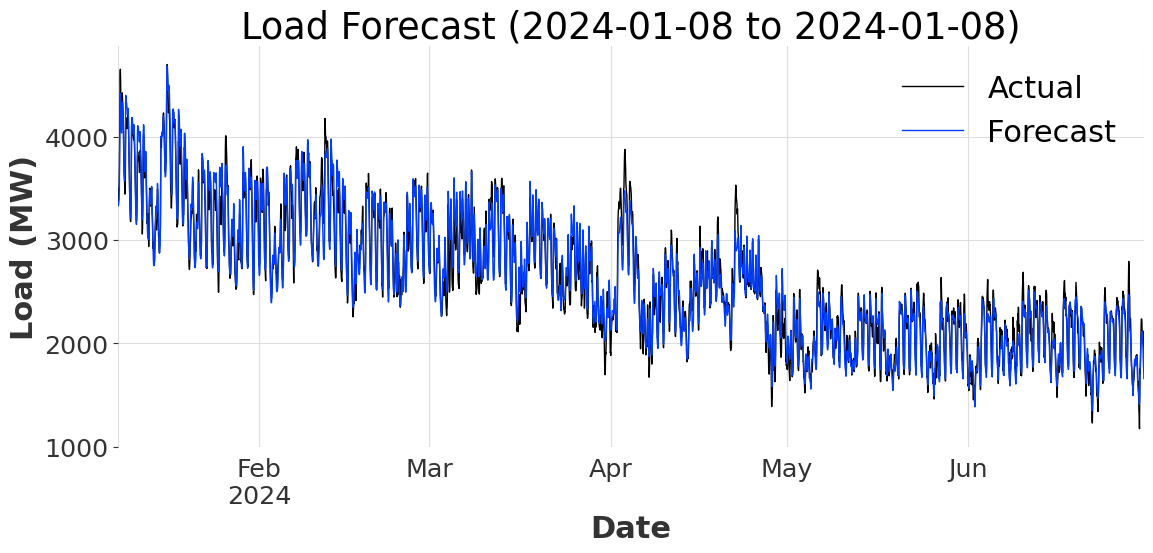

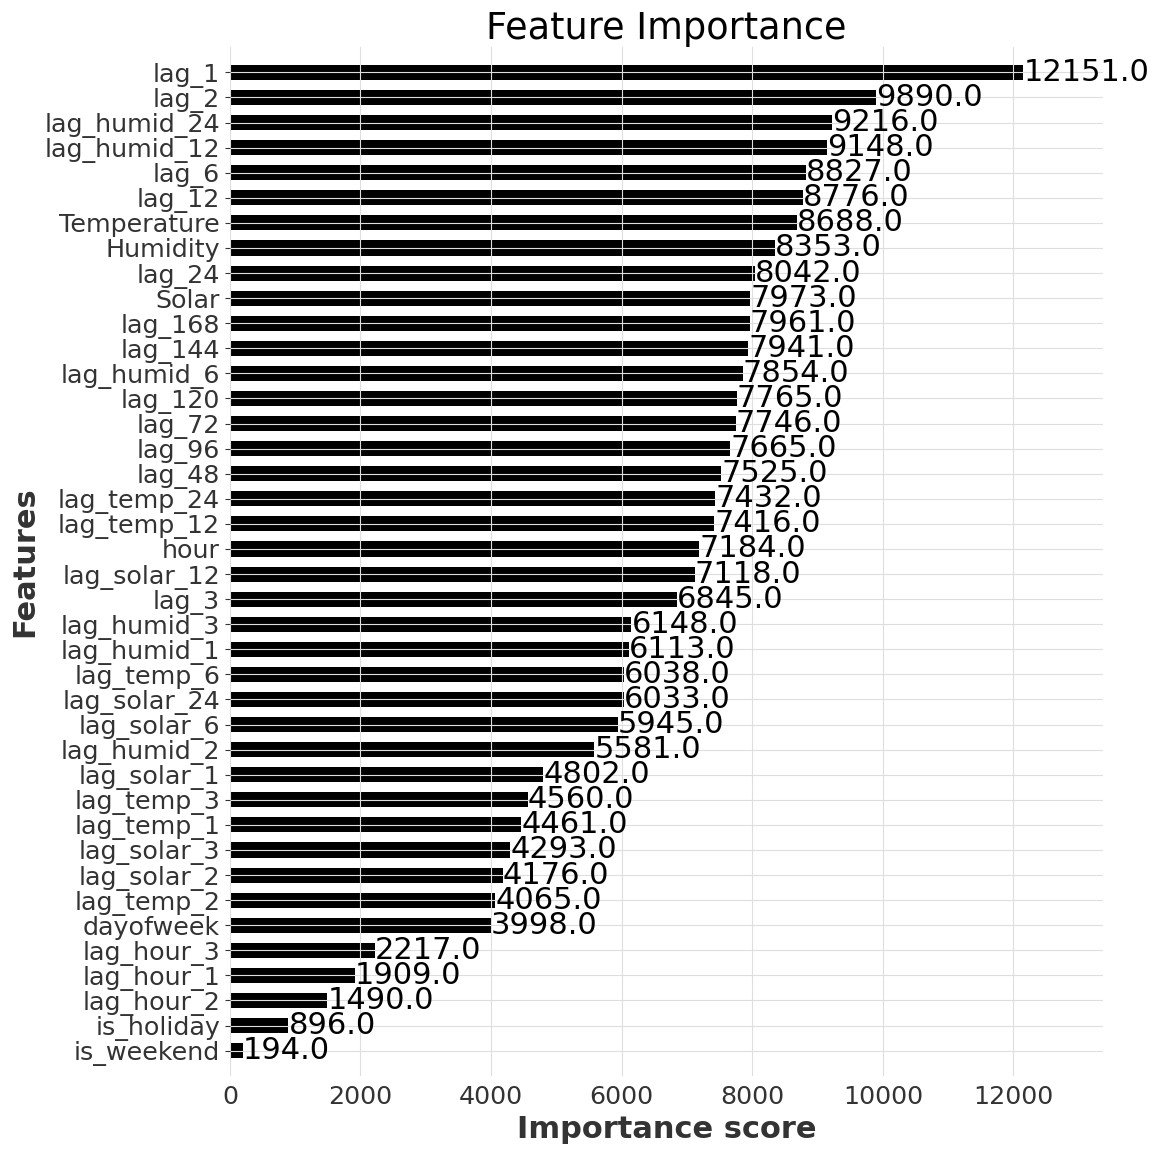

In [371]:
plot_forecast(y_val_pred.loc[final_val_predictions.index],final_val_predictions, best_model, "XGB.pdf", True)

MAPE: 5.11%
RMSE: 168.03
MAE: 124.38MW
Maximum MAPE: 15.20% on 2024-10-30
Minimum MAPE: 1.56% on 2024-11-13


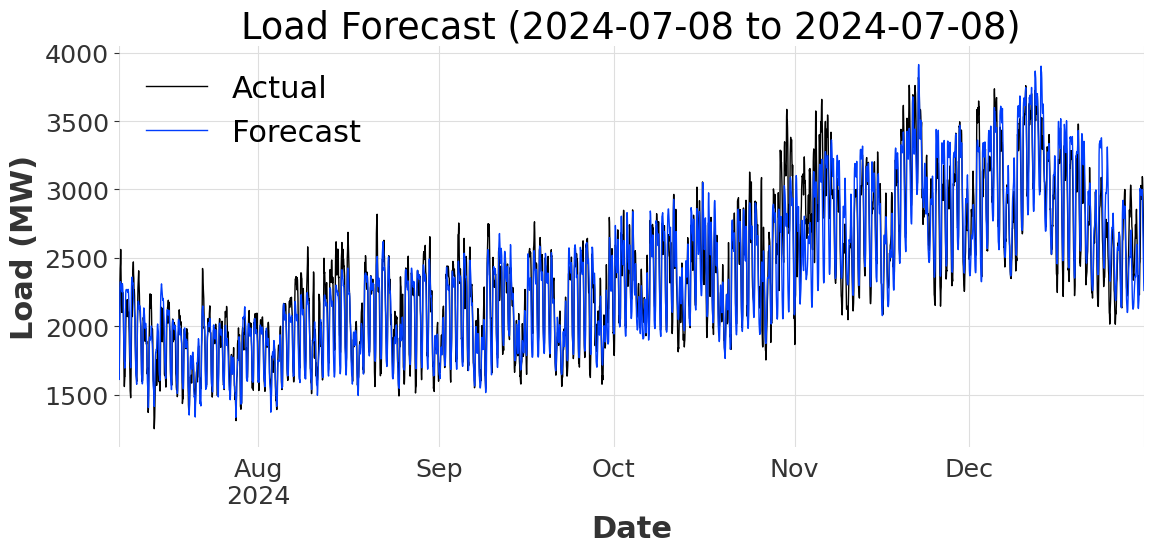

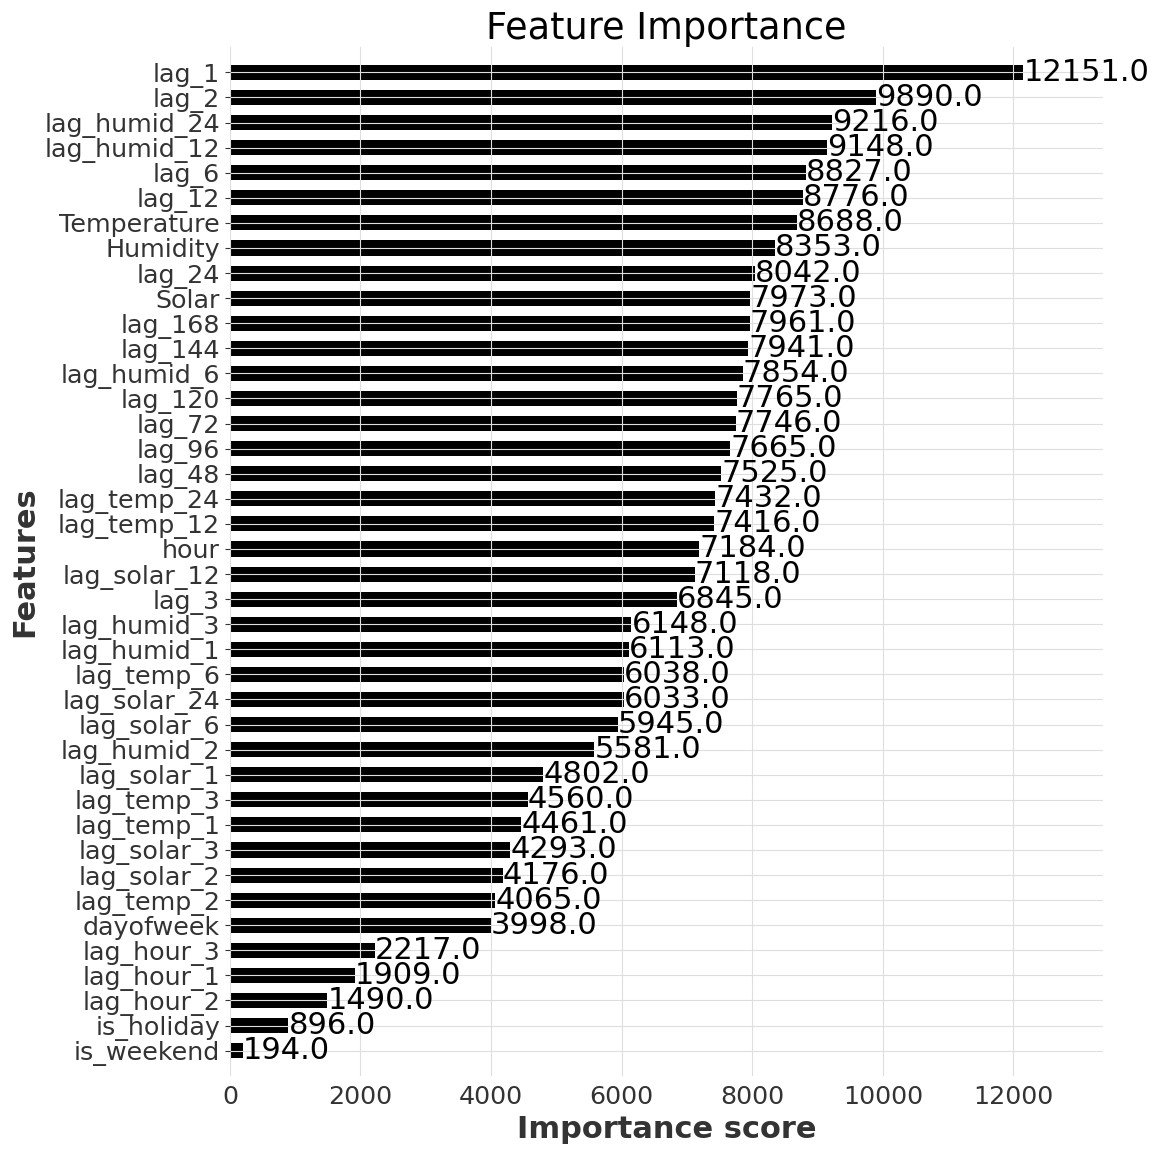

In [372]:
final_test_predictions = predict_XGB(best_model,X_test_pred,y_test_init,y_test_known, y_test_pred)
print_evaluation_metrics(y_test_pred.loc[final_test_predictions.index],final_test_predictions)
plot_forecast(y_test_pred.loc[final_test_predictions.index],final_test_predictions, best_model, xgb_feat=True)

Evaluation for final report

MAPE: 5.11%
RMSE: 168.03
MAE: 124.38MW
Maximum MAPE: 15.20% on 2024-10-30
Minimum MAPE: 1.56% on 2024-11-13


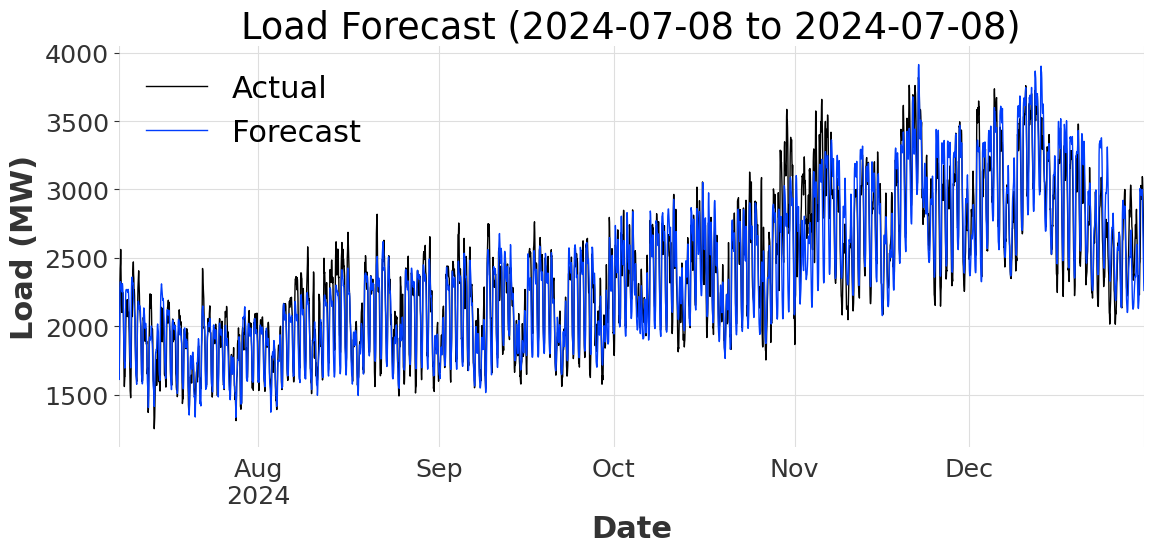

MAPE: 3.42%
RMSE: 86.42
MAE: 63.43MW
Maximum MAPE: 5.60% on 2024-07-26
Minimum MAPE: 1.81% on 2024-07-23


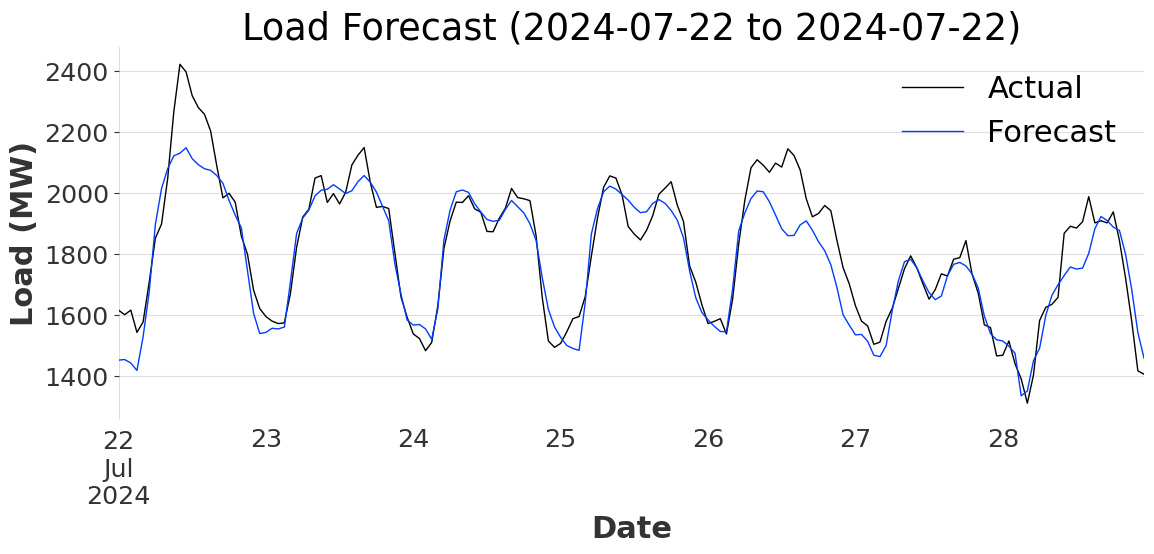

MAPE: 4.24%
RMSE: 125.32
MAE: 101.66MW
Maximum MAPE: 5.59% on 2024-10-16
Minimum MAPE: 2.91% on 2024-10-19


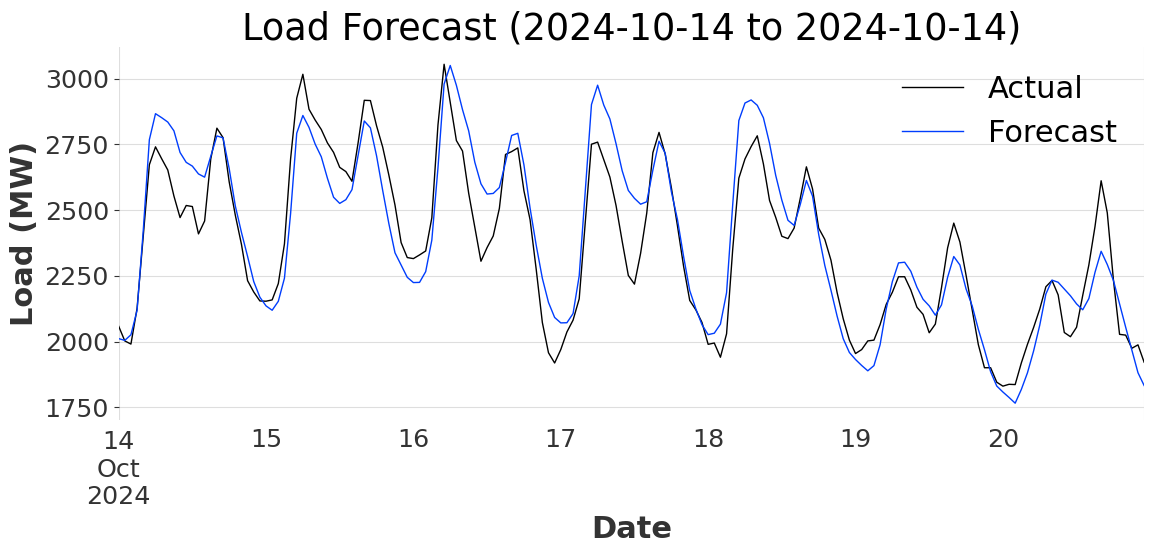

MAPE: 11.45%
RMSE: 395.75
MAE: 330.48MW
Maximum MAPE: 15.20% on 2024-10-30
Minimum MAPE: 5.93% on 2024-10-28


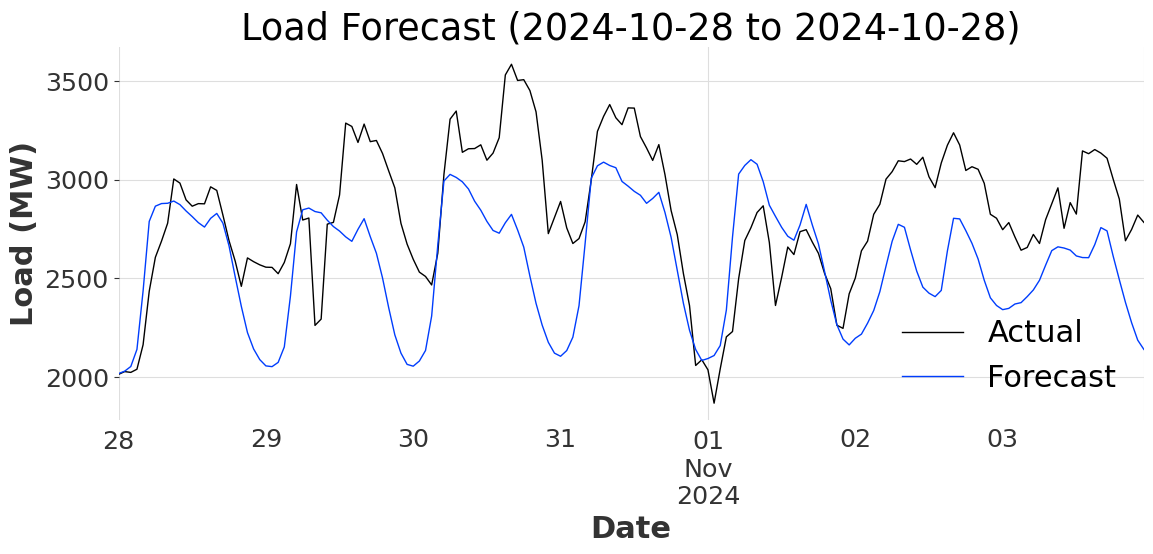

MAPE: 4.66%
RMSE: 165.18
MAE: 141.02MW
Maximum MAPE: 6.52% on 2024-12-02
Minimum MAPE: 2.57% on 2024-12-07


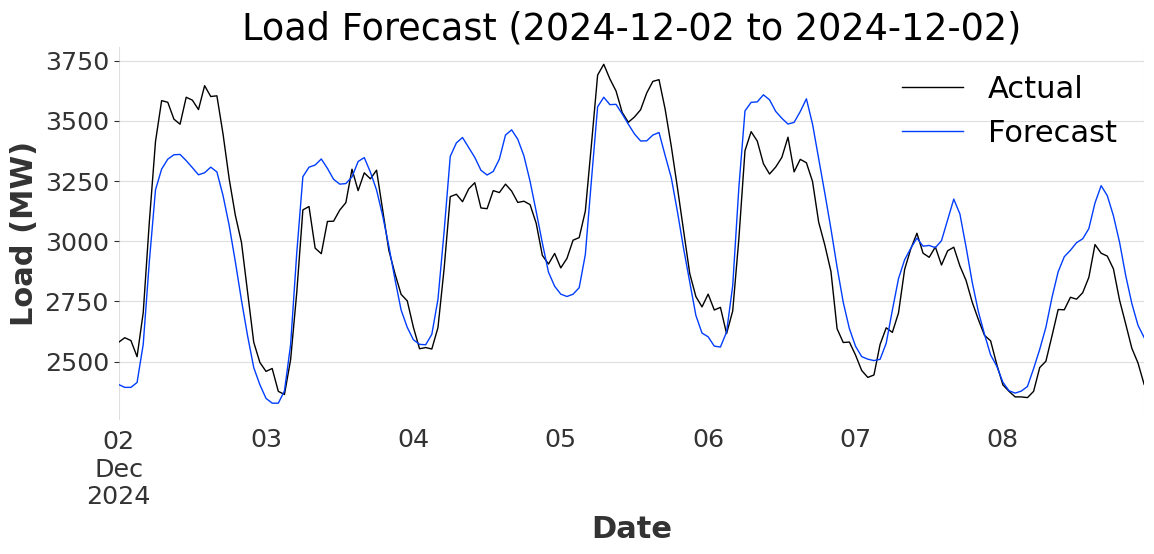

MAPE: 8.65%
RMSE: 258.29
MAE: 220.60MW
Maximum MAPE: 12.76% on 2024-12-23
Minimum MAPE: 4.15% on 2024-12-26


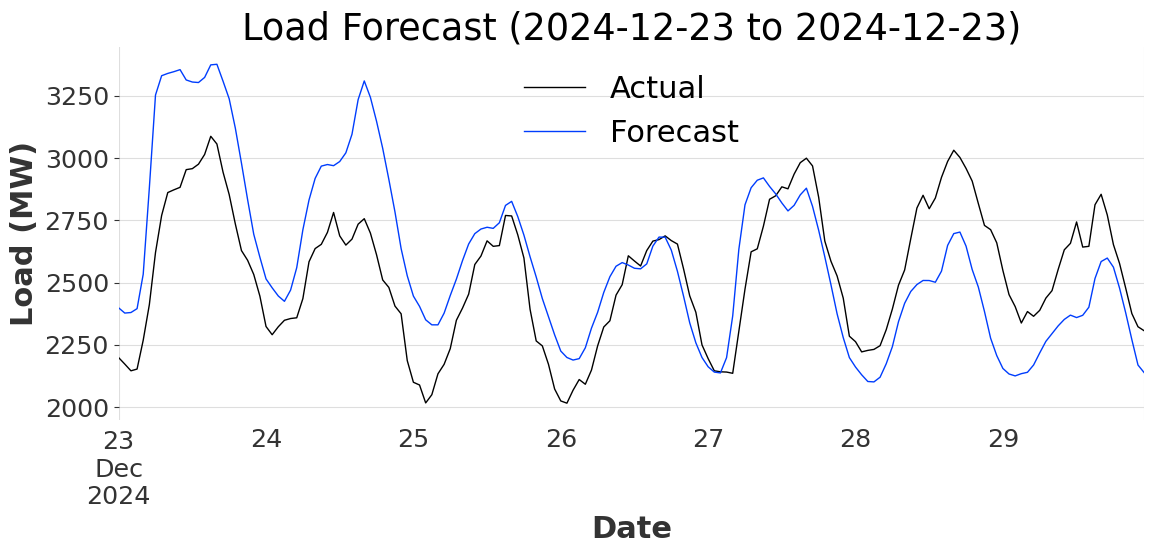

In [ ]:
eval_ranges = [
    ("2024-07-08", "2024-12-31"),
    ("2024-07-22", "2024-07-29"),
    ("2024-10-14", "2024-10-21"),
    ("2024-10-28", "2024-11-04"),
    ("2024-12-02", "2024-12-09"),
    ("2024-12-23", "2024-12-30"),
]
for start_date, end_date in eval_ranges:
    y_pred = y_test_pred[(y_test_pred.index>=start_date)&(y_test_pred.index<end_date)]
    print_evaluation_metrics(y_pred,final_test_predictions.loc[y_pred.index])
    plot_forecast(y_pred,final_test_predictions.loc[y_pred.index], best_model)
    

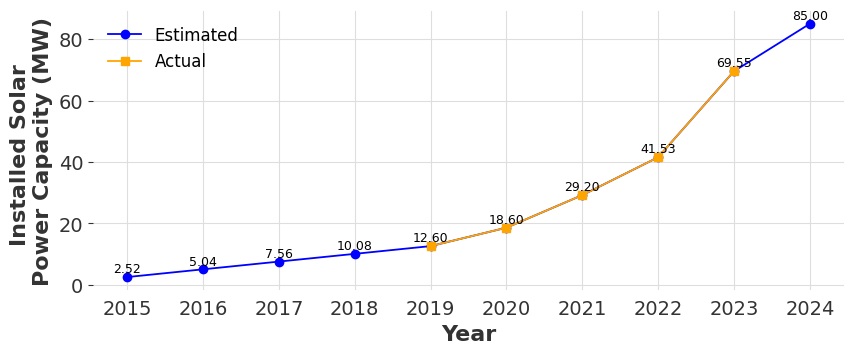

In [ ]:
years = list(range(2015, 2025))
solar_capacity = [2.52, 5.04, 7.56, 10.08, 12.6, 18.6, 29.2, 41.53, 69.55, 85.0]

plt.figure(figsize=(9, 4))

# Plot estimated start (2015–2018)
plt.plot(years, solar_capacity, marker='o', linestyle='-', color='blue', label='Estimated')

# Plot actual data (2019–2023)
plt.plot(years[4:9], solar_capacity[4:9], marker='s', linestyle='-', color='orange', label='Actual')

# Plot estimated end (2024), connecting to previous
#plt.plot(years[8:10], solar_capacity[8:10], marker='s', linestyle='-', color='gray')

# Annotate all points
for year, capacity in zip(years, solar_capacity):
    plt.text(year, capacity + 1.5, f'{capacity:.2f}', ha='center', fontsize=9)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Installed Solar \nPower Capacity (MW)', fontsize=16)
plt.grid(True)
plt.xticks(years, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("solar_power.pdf", format="pdf", bbox_inches="tight")
plt.show()
